In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [69]:
df = pd.read_csv("../../../data/class_credit_score_scaled.csv", index_col="ID")
target = "Credit_Score"

In [70]:
X = df.drop(target, axis=1)
y = df[target]
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
df = pd.concat([pd.DataFrame(trnX, columns=X.columns), pd.DataFrame(trnY, columns=[target])], axis=1)
df_test = pd.concat([pd.DataFrame(tstX, columns=X.columns), pd.DataFrame(tstY, columns=[target])], axis=1)
df_test.to_csv("../../../data/class_credit_score_test.csv")

Minority class= 0.0 : 7655
Majority class= 1.0 : 23077
Proportion: 0.33 : 1


<Axes: title={'center': 'Class balance'}>

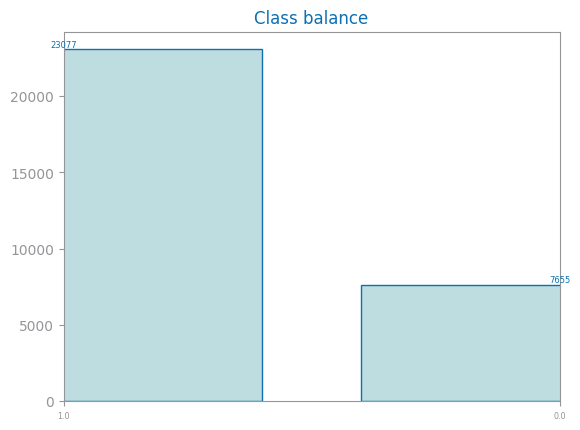

In [71]:
target_count = df[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}
dslab.plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)

In [72]:
df_positives = df[df[target] == positive_class]
df_negatives = df[df[target] == negative_class]

In [73]:
df_neg_sample = pd.DataFrame(df_negatives.sample(len(df_positives)))
df_under = pd.concat([df_positives, df_neg_sample], axis=0)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 0.0 : 7655
Majority class= 1.0 : 7655
Proportion: 1.0 : 1


In [74]:
df_pos_sample = pd.DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over = pd.concat([df_pos_sample, df_negatives], axis=0)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")
print(df_over.shape)

Minority class= 0.0 : 23077
Majority class= 1.0 : 23077
Proportion: 1.0 : 1
(46154, 33)


In [75]:
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)

X = df.drop(target, axis=1)
y = df[target]
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = pd.concat([pd.DataFrame(smote_X), pd.DataFrame(smote_y)], axis=1)
df_smote.columns = list(X.columns) + [target]

smote_target_count = pd.Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)


Minority class= 0.0 : 23077
Majority class= 1.0 : 23077
Proportion: 1.0 : 1
(46154, 33)


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import dslabs_functions as dslabs
import seaborn as sns

In [77]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, auc, f1

In [78]:
def generate_eval_chart(df, clf):
    target = "Credit_Score"
    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    print(f"Train#={len(X_train)} Test#={len(X_test)}")
    print(f"Labels={pd.unique(y_train)}")
    print(X_train.shape, y_train.shape)

    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    metrics_train = calculate_metrics(y_train, y_train_pred)
    metrics_test = calculate_metrics(y_test, y_test_pred)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1-Score'],
        'Training': metrics_train,
        'Test': metrics_test
    })
    metrics_melted = pd.melt(metrics_df, id_vars='Metric', var_name='Set', value_name='Score')

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    sns.barplot(ax=axs[0], x='Metric', y='Score', hue='Set', data=metrics_melted)
    axs[0].bar_label(axs[0].containers[0], fmt="%.2f")
    axs[0].bar_label(axs[0].containers[1], fmt="%.2f")

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, ax=axs[1], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    return fig, axs

Train#=24585 Test#=6147
Labels=[1. 0.]
(24585, 32) (24585,)


Text(0.5, 0.98, 'Without balancing (NB)')

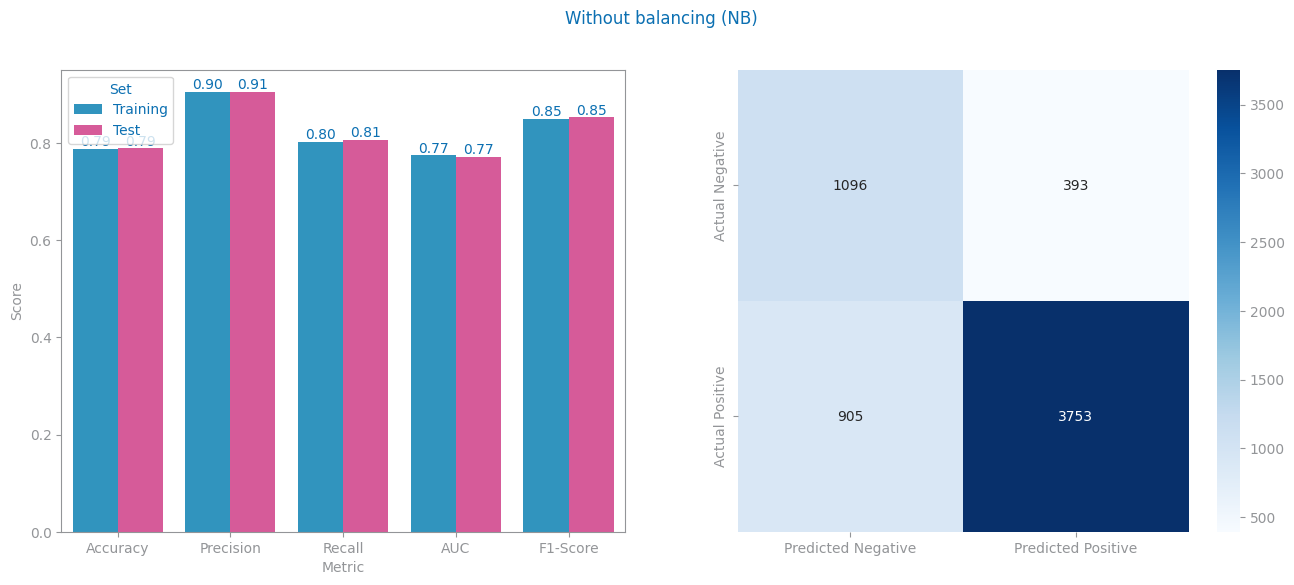

In [79]:
fig, axs = generate_eval_chart(df, GaussianNB())
fig.suptitle("Without balancing (NB)")

Train#=24585 Test#=6147
Labels=[1. 0.]
(24585, 32) (24585,)


Text(0.5, 0.98, 'Without balancing (KNN)')

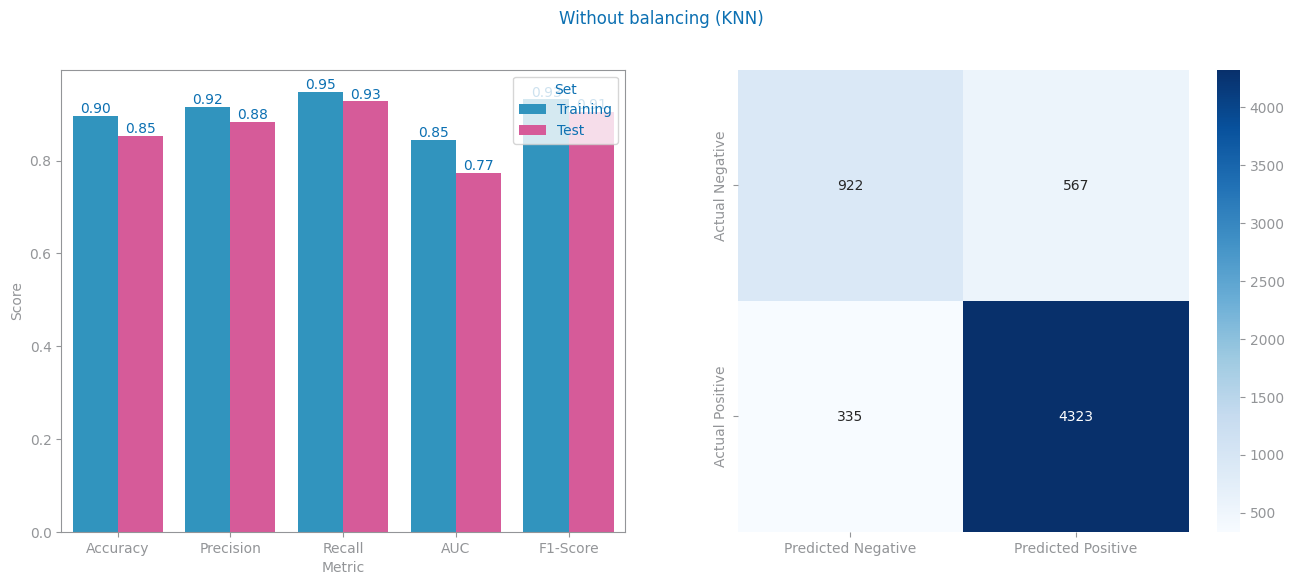

In [80]:
fig, axs = generate_eval_chart(df, KNeighborsClassifier())
fig.suptitle("Without balancing (KNN)")

Train#=12248 Test#=3062
Labels=[0. 1.]
(12248, 32) (12248,)


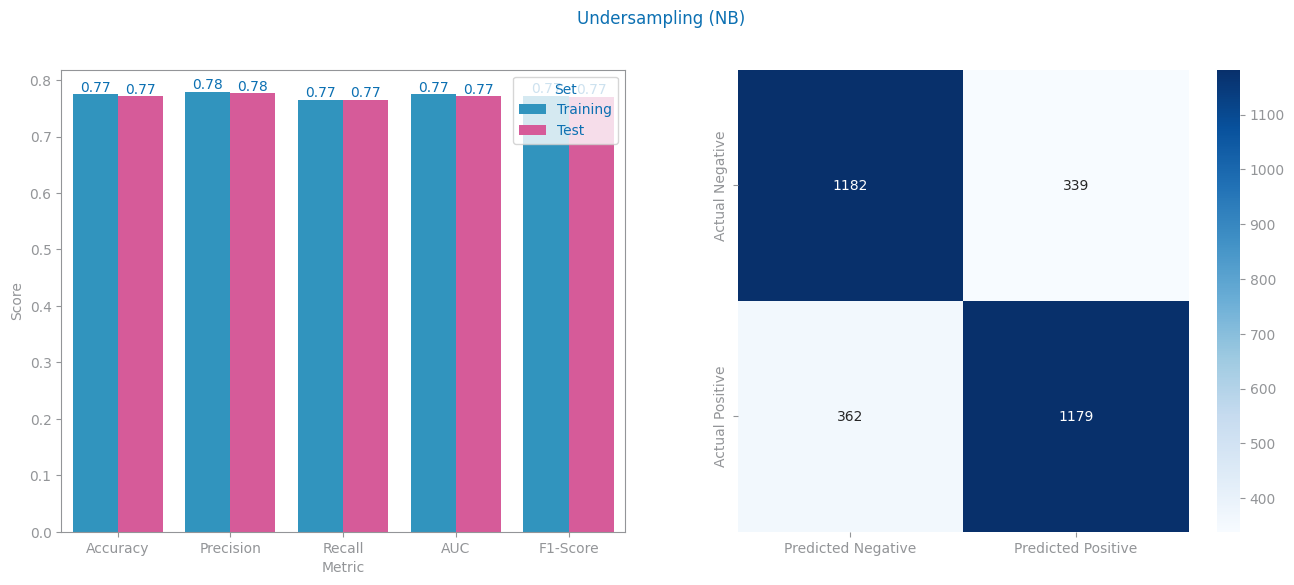

In [81]:
fig, axs = generate_eval_chart(df_under, GaussianNB())
fig.suptitle("Undersampling (NB)")
plt.savefig(f"images/service_balancing_undersampling_nb.png")

Train#=36923 Test#=9231
Labels=[1. 0.]
(36923, 32) (36923,)


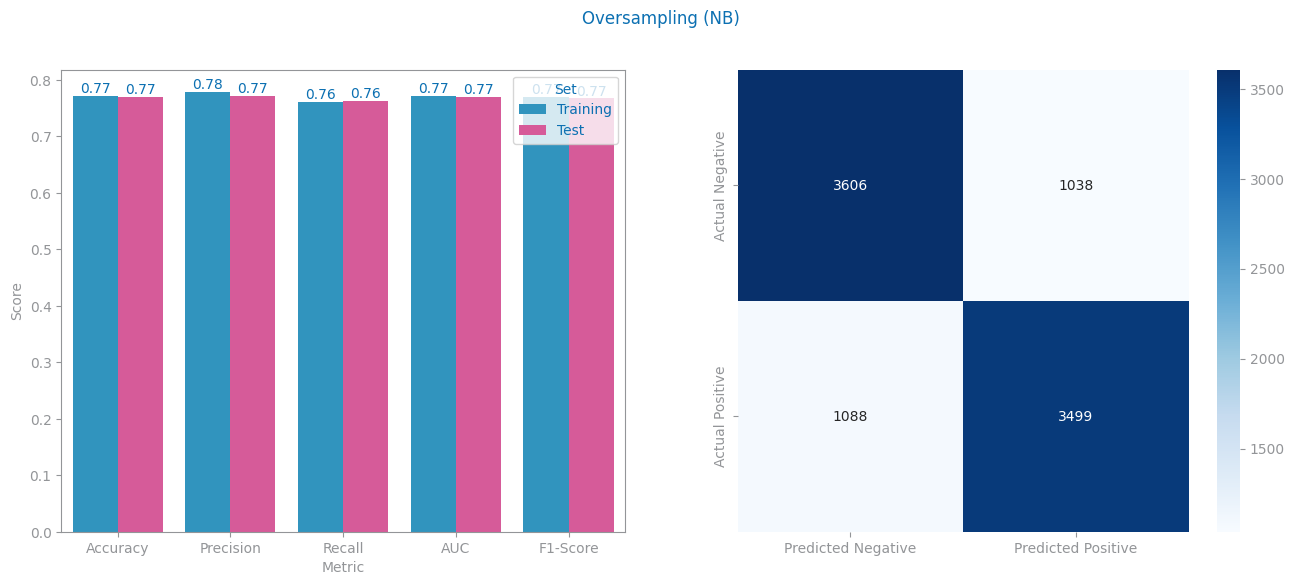

In [82]:
fig, axs = generate_eval_chart(df_over, GaussianNB())
fig.suptitle("Oversampling (NB)")
plt.savefig(f"images/service_balancing_oversampling_nb.png")

Train#=36923 Test#=9231
Labels=[0. 1.]
(36923, 32) (36923,)


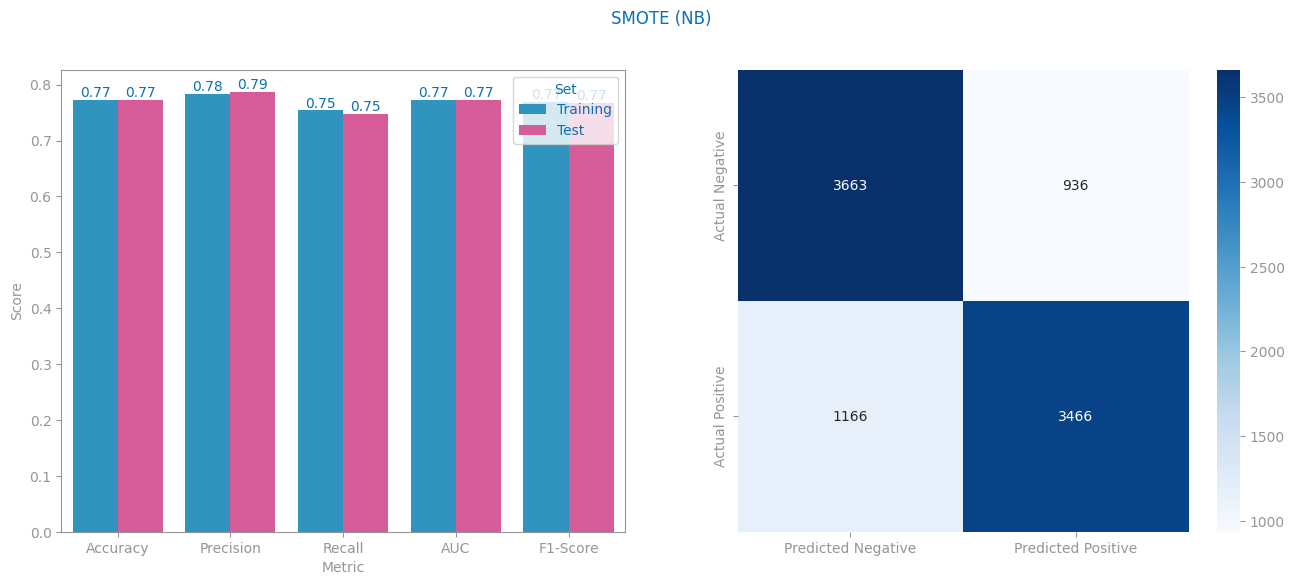

In [83]:
fig, axs = generate_eval_chart(df_smote, GaussianNB())
fig.suptitle("SMOTE (NB)")
plt.savefig(f"images/service_balancing_smote_nb.png")

Train#=12248 Test#=3062
Labels=[0. 1.]
(12248, 32) (12248,)


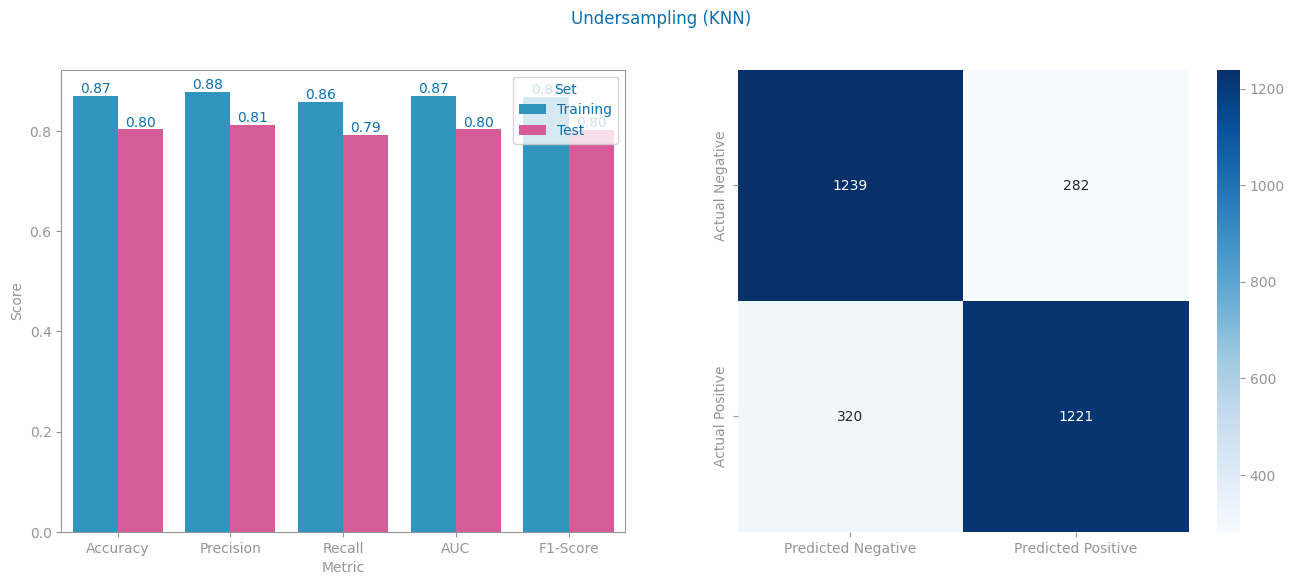

In [84]:
fig, axs = generate_eval_chart(df_under, KNeighborsClassifier())
fig.suptitle("Undersampling (KNN)")
plt.savefig(f"images/service_balancing_undersampling_knn.png")

Train#=36923 Test#=9231
Labels=[1. 0.]
(36923, 32) (36923,)


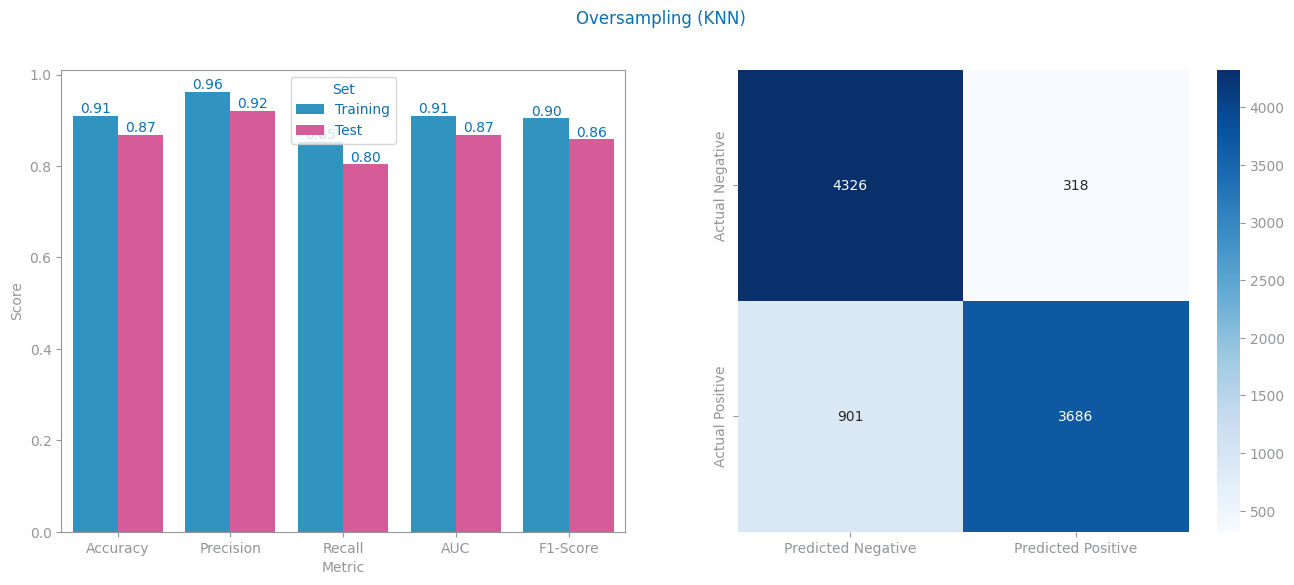

In [85]:
fig, axs = generate_eval_chart(df_over, KNeighborsClassifier())
fig.suptitle("Oversampling (KNN)")
plt.savefig(f"images/service_balancing_oversampling_knn.png")

Train#=36923 Test#=9231
Labels=[0. 1.]
(36923, 32) (36923,)


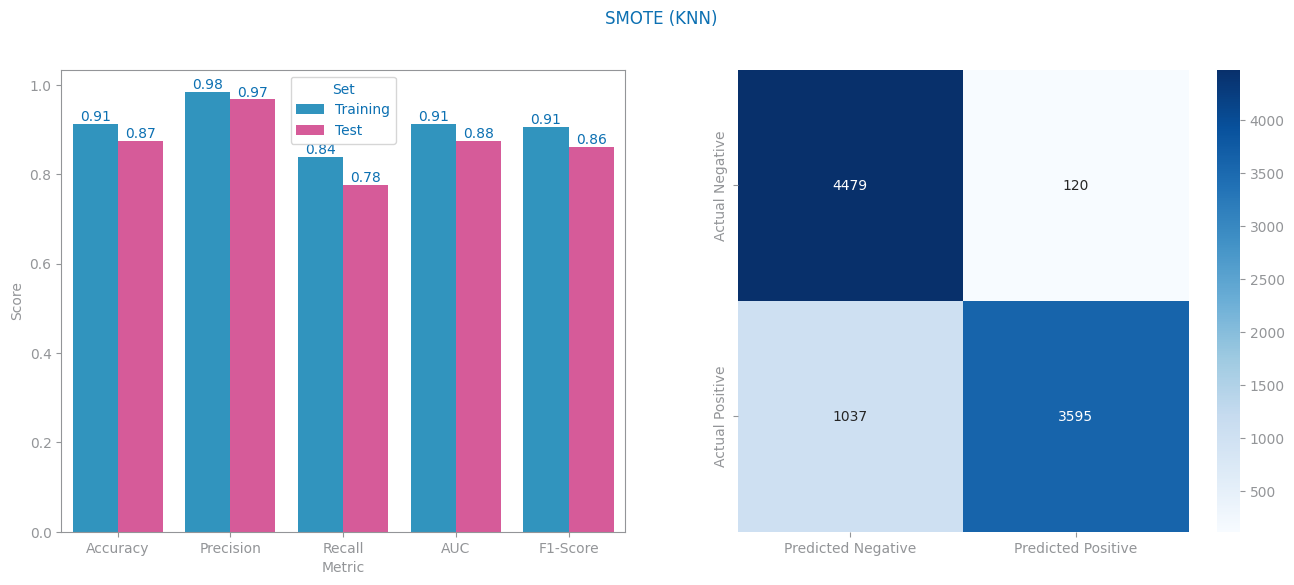

In [86]:
fig, axs = generate_eval_chart(df_smote, KNeighborsClassifier())
fig.suptitle("SMOTE (KNN)")
plt.savefig(f"images/service_balancing_smote_knn.png")

In [87]:
df.to_csv("../../../data/class_credit_score_train.csv")